In [429]:
# !pip install kaggle
# from google.colab import files
# files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c titanic
# !ls

Imports

In [430]:
# The usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regular expressions
import re

# LightGBM\XGBoost\GBDT
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import 

# Sklearn tools for model training and assessment
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score


Input Data

In [431]:
trainRaw = pd.read_csv('train.csv')
testRaw = pd.read_csv('test.csv')

# Concatenate together
TrainRow = trainRaw.shape[0]
allsets = pd.concat([trainRaw, testRaw], axis=0,sort=True).reset_index(drop=True)

trainRaw.name = 'Training Set'
testRaw.name = 'Test Set'
allsets.name = 'All Set'

all = [trainRaw, testRaw]

In [432]:
all

[     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
 0              1         0       3  ...   7.2500   NaN         S
 1              2         1       1  ...  71.2833   C85         C
 2              3         1       3  ...   7.9250   NaN         S
 3              4         1       1  ...  53.1000  C123         S
 4              5         0       3  ...   8.0500   NaN         S
 ..           ...       ...     ...  ...      ...   ...       ...
 886          887         0       2  ...  13.0000   NaN         S
 887          888         1       1  ...  30.0000   B42         S
 888          889         0       3  ...  23.4500   NaN         S
 889          890         1       1  ...  30.0000  C148         C
 890          891         0       3  ...   7.7500   NaN         Q
 
 [891 rows x 12 columns],      PassengerId  Pclass  ... Cabin Embarked
 0            892       3  ...   NaN        Q
 1            893       3  ...   NaN        S
 2            894       2  ...   NaN       

In [433]:
allsets

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


Missing Value

In [434]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in all:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




Age

In [435]:
age_by_pclass_sex = allsets.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [436]:
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(allsets['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [437]:
allsets['Age'] = allsets.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Embarked

In [438]:
allsets[allsets['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [439]:
# Filling the missing values in Embarked with S (Google)
allsets['Embarked'] = allsets['Embarked'].fillna('S')

Fare

In [440]:
allsets[allsets['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [441]:
# Fill the missing value in Farewith the median Fare of 3rd class alone passenger
med_fare = allsets.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

allsets['Fare'] = allsets['Fare'].fillna(med_fare)

Cabin

In [442]:
# Creating Deck column from the first letter of the Cabin column 
#(M stands for Missing)
allsets['Deck'] = allsets['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

#groupby Deck Pclass to see number of people
allsets_decks = allsets.groupby(['Deck', 
                                 'Pclass']).count().drop(columns=['Survived', 'Sex', 
                                                                  'Age', 'SibSp', 
                                                                  'Parch', 'Fare', 
                                                                  'Embarked', 'Cabin', 
                                                                  'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

In [443]:
allsets_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [444]:
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

all_deck_count, all_deck_per = get_pclass_dist(allsets_decks)

In [445]:
all_deck_count, all_deck_per

({'A': {1: 22, 2: 0, 3: 0},
  'B': {1: 65, 2: 0, 3: 0},
  'C': {1: 94, 2: 0, 3: 0},
  'D': {1: 40, 2: 6, 3: 0},
  'E': {1: 34, 2: 4, 3: 3},
  'F': {1: 0, 2: 13, 3: 8},
  'G': {1: 0, 2: 0, 3: 5},
  'M': {1: 67, 2: 254, 3: 693},
  'T': {1: 1, 2: 0, 3: 0}},
 {'A': [100.0, 0.0, 0.0],
  'B': [100.0, 0.0, 0.0],
  'C': [100.0, 0.0, 0.0],
  'D': [86.95652173913044, 13.043478260869565, 0.0],
  'E': [82.92682926829268, 9.75609756097561, 7.317073170731707],
  'F': [0.0, 61.904761904761905, 38.095238095238095],
  'G': [0.0, 0.0, 100.0],
  'M': [6.607495069033531, 25.04930966469428, 68.34319526627219],
  'T': [100.0, 0.0, 0.0]})

In [446]:
# Passenger in the T deck is changed to A
idx = allsets[allsets['Deck'] == 'T'].index
allsets.loc[idx, 'Deck'] = 'A'

In [447]:
allsets_decks_survived = allsets.groupby(['Deck', 
                                        'Survived']).count().drop(columns=['Sex', 'Age', 
                                                                           'SibSp', 'Parch', 
                                                                           'Fare', 'Embarked', 
                                                                           'Pclass', 'Cabin', 
                                                                           'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
allsets_decks_survived


Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

In [448]:
def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

all_surv_count, all_surv_per = get_survived_dist(allsets_decks_survived)

In [449]:
all_surv_count, all_surv_per

({'A': {0: 9, 1: 7},
  'B': {0: 12, 1: 35},
  'C': {0: 24, 1: 35},
  'D': {0: 8, 1: 25},
  'E': {0: 8, 1: 24},
  'F': {0: 5, 1: 8},
  'G': {0: 2, 1: 2},
  'M': {0: 481, 1: 206}},
 {'A': [56.25, 43.75],
  'B': [25.53191489361702, 74.46808510638297],
  'C': [40.67796610169492, 59.32203389830508],
  'D': [24.242424242424242, 75.75757575757575],
  'E': [25.0, 75.0],
  'F': [38.46153846153847, 61.53846153846154],
  'G': [50.0, 50.0],
  'M': [70.01455604075691, 29.985443959243085]})

Create new features

1.Fare

In [450]:
# Divide Fare to 13 range
allsets['Fare'] = pd.qcut(allsets['Fare'], 13)

2.Age

In [451]:
allsets['Age'] = pd.qcut(allsets['Age'], 10)

3.Cabin

Create a new feature - Deck from Cabin

In [452]:
allsets['Deck'] = allsets['Deck'].replace(['A', 'B', 'C'], 'ABC')
allsets['Deck'] = allsets['Deck'].replace(['D', 'E'], 'DE')
allsets['Deck'] = allsets['Deck'].replace(['F', 'G'], 'FG')

allsets['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [453]:
# # Build new features from Cabin
# # Seperate Canbin to Letter and Number for who has Canbin
# def CabSplit(s):
#     """
#     Function to try and extract cabin letter and number from the cabin column.
#     Runs a regular expression that finds letters and numbers in the
#     string. These are held in match.group, if they exist.
#     """
#     match = re.match(r"([a-z]+)([0-9]+)",s,re.I) #re.I 使匹配对大小写不敏感

#     try:
#         letter = match.group(1) #满足([a-z]+)的部分
#     except:
#         letter = ''

#     try:
#         number = match.group(2) #满足([0-9]+)的部分
#     except:
#         number = 9999
#     return letter, number

# # Count the number of Canbin
# def DR(s):
#     """
#     From the cabin string, try and extract letter, number, and number of cabins
#     """
#     # Check contents
#     if isinstance(s, (int,float)): 
#       # 若s是int或者float(只有数字形式) 
#       # 说明没有Cabin信息 为空 
#        letter = ''
#        number = ''
#        nCabins = 9999
#     else:
#        # If field isn't empty, split string to letter and unmber. 
#        # Some strings contain multiple cabins.
#        s = s.split(' ')
#        # Count the cabins based on number of splits
#        nCabins = len(s)
#        # Just take first cabin for letter/number extraction
#        s = s[0]

#        letter, number = CabSplit(s)

#     return [letter, number]

# # Apply DR function to each cell in Cabin column using pandas apply method.
# out = allsets['Cabin'].apply(DR)

# # Output tuple with 3 values for each row, convert this to pandas df
# out = out.apply(pd.Series)

# # name the columns
# out.columns = ['Cabletter','Cabnumber']

# # Concatenate these columns to the dataset
# allsets = pd.concat([allsets,out],axis = 1)      


In [454]:
# allsets

4.Family 

In [455]:
# Add some family features directly to new columns in the dataset

#size
allsets['fsize'] = allsets['SibSp'] + allsets['Parch'] + 1

#Ratio
allsets['fRatio'] = (allsets['Parch'] + 1)/(allsets['SibSp'] + 1)


family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
allsets['fsize_Grouped'] = allsets['fsize'].map(family_map)


In [456]:
# allsets

5.Tickets

In [457]:
# Count the number of different tickets
allsets['Ticket_Frequency'] = allsets.groupby('Ticket')['Ticket'].transform('count')


In [458]:
# TicketDict = {
#     "A./5.": "A",
#     "A.5.": "A",
#     "A/4": "A",
#     "A/4.": "A",
#     "A/5": "A",
#     "A/5.": "A",
#     "A/S": "A",
#     "A4.": "A",
#     "C": "C",
#     "C.A.":"C",
#     "CA.": "C",
#     "C.A./": "C",
#     "CA": "C",
#     "F.C.": "FC",
#     "F.C.C.": "FC",
#     "LINE":"LINE",
#     "PC": "PC",
#     "PP": "PC",
#     "SOTON/O.Q.": "SO",
#     "SOTON/O2": "SO",
#     "SOTON/OQ": "SO",
#     "STON/O" : "ST",
#     "STON/O2.": "ST"
# }

# def splitTic(s):

#     match = re.match(r"([0-9]+)", s, re.I)

#     try:
#         number = int(match.group(1))
#     except:
#         number = s

#     return number


# def SP(s, TicketDict):
#     s = splitTic(s)
#     if isinstance(s, (int)):
#        if s <= 9999:
#           tic = 'a'
#        if ((s >= 10000) and (s < 99999)):
#           tic = 'b'
#        if ((s >= 100000) and (s < 999999)):
#           tic = 'c'
#        else:
#           tic = 'd'
#     else:
#        s = s.split(' ')
      
#        tic = [t for k, t in TicketDict.items() if str(k) in s]
      
#        if tic == []:
#         tic = 'Other'
#        else:
#         # Title is a list, so extract contents
#         tic = tic[0]
      
#     return tic

# # out = allsets['Ticket'].apply(splitTic, args=[TicketDict])
# out = allsets['Ticket'].apply(SP, args = [TicketDict])
# out = out.apply(pd.Series)
# out.columns = ['Tickettype']

# allsets = pd.concat([allsets,out],axis=1)


6.Name/Title/Is_Married

In [459]:
# Extract titles from Name column, standardise
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}

def NameSplit(s, titleDict):
    """
    Extract title from name, replace with value in title dictionary. Also
    return surname.
    """

    # Remove '.' from name string
    s = s.replace('.','')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    #get title - loop over titleDict
    #if s matches a key, take the corresponding value as the tile
    title = []
    for k, t in titleDict.items():
      if str(k) in s:
        title.append(t)
        
    if title == []:
        title = 'other'
    else:
        # Title is a list, so extract contents
        title = title[0]
    return title

out = allsets['Name'].apply(NameSplit,args=[titleDict])

out = out.apply(pd.Series)
out.columns = ['Title']
allsets = pd.concat([allsets, out],axis=1)


In [460]:
allsets['Is_Married'] = 0
allsets['Is_Married'].loc[allsets['Title'] == 'Mrs'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [461]:
allsets['Title'] = allsets['Title'].replace(['Miss', 'Mrs','Ms', 'Lady'], 'Miss/Mrs/Ms')
allsets['Title'] = allsets['Title'].replace(['Officer','Sir','Dr','Rev'], 'Dr/Military/Noble/Clergy')

In [462]:
allsets.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
0,"(21.0, 22.0]",NaN,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2,0.5,Small,1,Mr,0
1,"(34.0, 40.0]",C85,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,2,0.5,Small,2,Miss/Mrs/Ms,1
2,"(25.0, 26.0]",NaN,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1,1.0,Alone,1,Miss/Mrs/Ms,0
3,"(34.0, 40.0]",C123,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,2,0.5,Small,2,Miss/Mrs/Ms,1
4,"(34.0, 40.0]",NaN,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1,1.0,Alone,1,Mr,0


In [463]:
# List of categorical columns to record
catCols = ['Age','Sex', 'Embarked', 'Fare',
           'Title','Deck',
           'fsize_Grouped']

for c in catCols:
    # Convert column to pd.Catgorical
    # 找出有几个类别
    allsets[c] = pd.Categorical(allsets[c])
    # Extract the cat.codes and replace the column with these
    # 把类别转换成数字
    allsets[c] = allsets[c].cat.codes
    # Convert the cat codes to categorical 
    # 把dtype 从int8改为category
    allsets[c] = pd.Categorical(allsets[c])


# Generate a logical index of categorical columns to maybe use with LightGBM later
# catCols = [i for i,v in enumerate(allsets.dtypes) if str(v)=='category']



In [464]:
allsets

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
0,2,NaN,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,3,2,0.5,3,1,3,0
1,7,C85,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,0,2,0.5,3,2,2,1
2,4,NaN,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,3,1,1.0,0,1,2,0
3,7,C123,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0,2,0.5,3,2,2,1
4,7,NaN,2,3,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,3,1,1.0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,NaN,2,3,"Spector, Mr. Woolf",0,1305,3,1,0,NaN,A.5. 3236,3,1,1.0,0,1,3,0
1305,7,C105,0,12,"Oliva y Ocana, Dona. Fermina",0,1306,1,0,0,NaN,PC 17758,0,1,1.0,0,3,2,0
1306,7,NaN,2,0,"Saether, Mr. Simon Sivertsen",0,1307,3,1,0,NaN,SOTON/O.Q. 3101262,3,1,1.0,0,1,3,0
1307,3,NaN,2,3,"Ware, Mr. Frederick",0,1308,3,1,0,NaN,359309,3,1,1.0,0,1,3,0


In [465]:
# Split datasets
train = allsets.iloc[0:TrainRow,:]
test = allsets.iloc[TrainRow:,:]

# Prepare data
def prepLGB(data, classCol='', IDCol='',fDrop=[]):
    
    # Drop class column
    if classCol != '':
        labels = data[classCol]
        fDrop = fDrop + [classCol] 
    else:
        labels = []

    if IDCol != '':
        IDs = data[IDCol]
    else:
        IDs = []

    if fDrop != []:
       data = data.drop(fDrop, axis = 1)

    # Creat LGB mats
    # 创建成lgb特征的数据集格式
    lgbData = lgb.Dataset(data, label=labels, 
                          free_raw_data=False,
                          feature_name=list(data.columns),
                          categorical_feature = 'auto')
    
    # lgbData是lgb特征的数据集格式,包含label
    # data就是drop了label之后的正常train set
    # labels 就是train里的 'y' 
    return lgbData, labels, IDs, data


# Specify columns to drop
fDrop = ['Ticket', 'Cabin', 'Name', 'PassengerId']

In [466]:
train

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
0,2,NaN,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,3,2,0.5,3,1,3,0
1,7,C85,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,0,2,0.5,3,2,2,1
2,4,NaN,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,3,1,1.0,0,1,2,0
3,7,C123,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0,2,0.5,3,2,2,1
4,7,NaN,2,3,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,3,1,1.0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,5,NaN,2,5,"Montvila, Rev. Juozas",0,887,2,1,0,0.0,211536,3,1,1.0,0,1,0,0
887,1,B42,2,9,"Graham, Miss. Margaret Edith",0,888,1,0,0,1.0,112053,0,1,1.0,0,1,2,0
888,2,NaN,2,8,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,0,1,0.0,W./C. 6607,3,4,1.5,3,4,2,0
889,4,C148,0,9,"Behr, Mr. Karl Howell",0,890,1,1,0,1.0,111369,0,1,1.0,0,1,3,0


In [467]:
# Split training data into training and validation sets
# Validation set is used for early stopping
trainData, validData = train_test_split(train, test_size = 0.3, 
                                        stratify=train.Survived,
                                        random_state=28)

# Prepare the data sets
trainDatalgb, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                         classCol = 'Survived',
                                                         IDCol = 'PassengerId', 
                                                         fDrop = fDrop)

validDatalgb, validLabels, validIDs, validData = prepLGB(validData,
                                                         classCol = 'Survived',
                                                         IDCol = 'PassengerId',
                                                         fDrop = fDrop)

testDatalgb, _, _, testData = prepLGB(test, 
                                      classCol='Survived',
                                      IDCol='PassengerId',
                                      fDrop=fDrop)

# Prepare data set using all the training data
allTrainDatalgb, allTrainLabels, _, allTrainData = prepLGB(train, 
                                                           classCol='Survived',
                                                           IDCol='PassengerId',
                                                           fDrop=fDrop)






In [468]:
trainDatalgb.data

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
520,6,2,12,0,1,0,0,0,1,1.00,0,4,2,0
241,2,1,6,0,3,0,1,3,2,0.50,3,2,2,0
88,3,2,12,2,1,0,3,0,6,0.75,2,6,2,0
20,7,2,8,0,2,1,0,3,1,1.00,0,2,3,0
874,5,0,8,0,2,0,1,3,2,0.50,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,8,2,4,1,3,1,0,3,2,2.00,3,1,3,0
224,7,2,12,0,1,1,1,0,2,0.50,3,2,3,0
522,3,0,0,0,3,1,0,3,1,1.00,0,1,3,0
512,7,2,8,0,1,1,0,1,1,1.00,0,1,3,0


In [469]:
validData

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
232,9,2,6,0,2,1,0,3,1,1.0,0,1,3,0
342,5,2,5,0,2,1,0,3,1,1.0,0,1,3,0
801,6,2,8,1,2,0,1,3,3,1.0,3,3,2,1
510,5,1,1,0,3,1,0,3,1,1.0,0,1,3,0
269,7,2,12,0,1,0,0,0,1,1.0,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,5,2,7,0,3,1,1,3,2,0.5,3,2,3,0
31,7,0,12,0,1,0,1,0,2,0.5,3,3,2,1
880,3,2,8,1,2,0,0,3,2,2.0,3,2,2,1
742,1,0,12,2,1,0,2,0,5,1.0,2,7,2,0


In [470]:
trainDatalgb.data

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Deck,fsize,fRatio,fsize_Grouped,Ticket_Frequency,Title,Is_Married
520,6,2,12,0,1,0,0,0,1,1.00,0,4,2,0
241,2,1,6,0,3,0,1,3,2,0.50,3,2,2,0
88,3,2,12,2,1,0,3,0,6,0.75,2,6,2,0
20,7,2,8,0,2,1,0,3,1,1.00,0,2,3,0
874,5,0,8,0,2,0,1,3,2,0.50,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,8,2,4,1,3,1,0,3,2,2.00,3,1,3,0
224,7,2,12,0,1,1,1,0,2,0.50,3,2,3,0
522,3,0,0,0,3,1,0,3,1,1.00,0,1,3,0
512,7,2,8,0,1,1,0,1,1,1.00,0,1,3,0


In [471]:
# trainDatalgb 的数据类型：<lightgbm.basic.Dataset at 0x7f0556a2a650>

In [472]:
# Without tuning and early stopping
params = {'boosting_type': 'gbdt', # traditional GBDT
          'max_depth' : -1, # <= 0 means no limit
          'objective': 'binary', # 二分类
          'nthread': 3, # Updated from nthread
          'num_leaves': 31, # Maximum tree leaves for base learners
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8, # Subsample ratio of columns when constructing each tree
          'reg_alpha': 5, # L1 regularization term on weights
          'reg_lambda': 10, # L2 regularization term on weights.
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 2,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }


In [473]:
# # Create parameters to search 进行调参
# gridParams = {
#     'learning_rate':[0.05,0.1,0.5],
#     'n_estimators':[40,100,200],
#     'num_leaves':[6,16,24,31],
#     'boosting_type':['gbdt'],
#     'objective':['binary'],
#     'random_state':[28],
#     'colsample_bytree': [0.65, 0.66],
#     'subsample':[0.7,0.75],
#     'reg_alpha':[0,1,2,5],
#     'reg_lambda':[0,1,5]
#     }

In [474]:
# # Create classifier to use
# lgbmodel = lgb.LGBMClassifier(boosting_type = 'gbdt',
#                               objective = 'binary',
#                               n_job = 3,
#                               silent = True,
#                               max_depth = params['max_depth'],
#                               max_bin = params['max_bin'],
#                               subsample_for_bin = params['subsample_for_bin'],
#                               subsample = params['subsample'],
#                               subsample_freq = params['subsample_freq'],
#                               min_split_gain = params['min_split_gain'],
#                               min_child_weight = params['min_child_weight'],
#                               min_child_samples = params['min_child_samples'],
#                               scale_pos_weight = params['scale_pos_weight'])


In [475]:
# View the default model params:
# lgbmodel.get_params()

In [476]:
# # Create the grid
# grid = GridSearchCV(lgbmodel, gridParams,
#                     verbose = 0,
#                     cv = 4,
#                     n_jobs = 2)

# # Run the grid
# grid.fit(allTrainData, allTrainLabels)

# # Print the best parameters founf
# print(grid.best_params_)
# print(grid.best_score_)

# # grid.fit()：运行网格搜索
# # grid_scores_：给出不同参数情况下的评价结果
# # best_params_：描述了已取得最佳结果的参数的组合
# # best_score_：提供优化过程期间观察到的最好的评分


In [477]:
# # Using parameters already set above, replace in the best from the grid search
# params['colsample_bytree'] = grid.best_params_['colsample_bytree']
# params['learning_rate'] = grid.best_params_['learning_rate']
# # params['learning_rate'] = 0.1
# params['num_leaves'] = grid.best_params_['num_leaves']
# # params['num_leaves'] =31
# params['reg_alpha'] = grid.best_params_['reg_alpha']
# # params['reg_alpha'] = 1
# params['reg_lambda'] = grid.best_params_['reg_lambda']
# params['subsample'] = grid.best_params_['subsample']
# # params['subsample'] =  0.7
# params['n_estimators'] = grid.best_params_['n_estimators']
# # params['n_estimators'] = 400

# print('Fitting with params: ')
# print(params)

In [478]:
gbm = lgb.train(params,
                trainDatalgb,
                100000,
                valid_sets=[trainDatalgb, validDatalgb],
                early_stopping_rounds=50,
                verbose_eval=4)

Training until validation scores don't improve for 50 rounds.
[4]	training's binary_error: 0.383628	valid_1's binary_error: 0.384328
[8]	training's binary_error: 0.207063	valid_1's binary_error: 0.257463
[12]	training's binary_error: 0.200642	valid_1's binary_error: 0.257463
[16]	training's binary_error: 0.197432	valid_1's binary_error: 0.25
[20]	training's binary_error: 0.170144	valid_1's binary_error: 0.208955
[24]	training's binary_error: 0.184591	valid_1's binary_error: 0.201493
[28]	training's binary_error: 0.184591	valid_1's binary_error: 0.201493
[32]	training's binary_error: 0.184591	valid_1's binary_error: 0.201493
[36]	training's binary_error: 0.162119	valid_1's binary_error: 0.205224
[40]	training's binary_error: 0.168539	valid_1's binary_error: 0.201493
[44]	training's binary_error: 0.170144	valid_1's binary_error: 0.208955
[48]	training's binary_error: 0.170144	valid_1's binary_error: 0.208955
[52]	training's binary_error: 0.170144	valid_1's binary_error: 0.208955
[56]	tra

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [423]:
lgbmodel = lgb.LGBMClassifier(
          boosting_type = 'gbdt', 
          max_depth = -1, 
          objective = 'binary',
          nthread = 3, 
          num_leaves = 16, 
          learning_rate =  0.1, 
          max_bin = 512, 
          subsample_for_bin = 200,
          subsample = 0.75,
          subsample_freq = 1,
          colsample_bytree = 0.65, 
          reg_alpha = 0, 
          reg_lambda = 1, 
          min_split_gain = 0.5,
          min_child_weight = 1,
          min_child_samples = 2,
          scale_pos_weight = 1,
          num_class = 1,
          metric = 'binary_error',
          n_estimators = 200)

lgbmodel.fit(trainData, trainLabels, eval_set=[(trainData, trainLabels), (validData, validLabels)], eval_metric='error',early_stopping_rounds=50)
 

[1]	training's binary_error: 0.383628	valid_1's binary_error: 0.384328
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_error: 0.383628	valid_1's binary_error: 0.384328
[3]	training's binary_error: 0.242376	valid_1's binary_error: 0.287313
[4]	training's binary_error: 0.203852	valid_1's binary_error: 0.261194
[5]	training's binary_error: 0.194222	valid_1's binary_error: 0.261194
[6]	training's binary_error: 0.187801	valid_1's binary_error: 0.257463
[7]	training's binary_error: 0.17496	valid_1's binary_error: 0.227612
[8]	training's binary_error: 0.176565	valid_1's binary_error: 0.227612
[9]	training's binary_error: 0.176565	valid_1's binary_error: 0.201493
[10]	training's binary_error: 0.168539	valid_1's binary_error: 0.186567
[11]	training's binary_error: 0.166934	valid_1's binary_error: 0.186567
[12]	training's binary_error: 0.154093	valid_1's binary_error: 0.190299
[13]	training's binary_error: 0.163724	valid_1's binary_error: 0.186567
[14]	trainin

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
               importance_type='split', learning_rate=0.1, max_bin=512,
               max_depth=-1, metric='binary_error', min_child_samples=2,
               min_child_weight=1, min_split_gain=0.5, n_estimators=200,
               n_jobs=-1, nthread=3, num_class=1, num_leaves=16,
               objective='binary', random_state=None, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, silent=True, subsample=0.75,
               subsample_for_bin=200, subsample_freq=1)

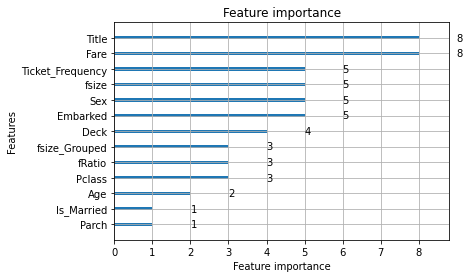

In [424]:
lgb.plot_importance(gbm)
plt.show()

In [425]:
predtest = gbm.predict(testData)

In [426]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = np.int32(predtest >= 0.5)

In [427]:
submission

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [428]:
submission.to_csv('Titanic.csv',index=False)
from google.colab import files
files.download('Titanic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>